# Classify names to the country they might correspond

Classifying names with a character-level RNN

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [2]:
def findFiles(path):
    return glob.glob(path)

print(findFiles('name_data/names/*.txt'))

['name_data/names\\Arabic.txt', 'name_data/names\\Chinese.txt', 'name_data/names\\Czech.txt', 'name_data/names\\Dutch.txt', 'name_data/names\\English.txt', 'name_data/names\\French.txt', 'name_data/names\\German.txt', 'name_data/names\\Greek.txt', 'name_data/names\\Irish.txt', 'name_data/names\\Italian.txt', 'name_data/names\\Japanese.txt', 'name_data/names\\Korean.txt', 'name_data/names\\Polish.txt', 'name_data/names\\Portuguese.txt', 'name_data/names\\Russian.txt', 'name_data/names\\Scottish.txt', 'name_data/names\\Spanish.txt', 'name_data/names\\Vietnamese.txt']


In [3]:
all_letters = string.ascii_letters + ".,;''"
n_letters = len(all_letters)

print(all_letters)
print()
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;''

57


# Transform from unicode to ascii

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

In [5]:
print(unicodeToAscii('Björn'))

Bjorn


In [6]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('name_data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)
n_categories

18

In [7]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Turning names to tensors
Create tensor of size (line_length X 1 X n_letters). Middle index is for batch.

In [13]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)


def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [14]:
print(letterToTensor('J'))
print()
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

torch.Size([5, 1, 57])


# Create the network

Network architecture.


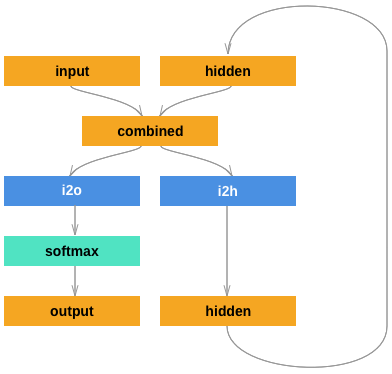

In [52]:
from IPython.display import Image, display
print('Network architecture.')

Image('https://i.imgur.com/Z2xbySO.png')

In [15]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
        
        
        
        

In [18]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

print(output)

tensor([[-2.8935, -2.8223, -2.8285, -2.9169, -3.0212, -2.8737, -2.8059, -2.8878,
         -2.9411, -2.8944, -2.9036, -2.9702, -2.9273, -2.8366, -2.8660, -2.9092,
         -2.9874, -2.7762]], grad_fn=<LogSoftmaxBackward>)


# Prepare for training

In [21]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 17)


In [22]:

import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, '/ line = ', line)

category =  Vietnamese / line =  Luong
category =  Korean / line =  Sin
category =  French / line =  Duchamps
category =  Portuguese / line =  Ferreira
category =  Korean / line =  Cha
category =  Greek / line =  Avgerinos
category =  Japanese / line =  Futabatei
category =  Arabic / line =  Ganim
category =  Dutch / line =  Rompaye
category =  Vietnamese / line =  Cao


In [26]:
criterion = nn.NLLLoss()

learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # update parameters
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item()
        

In [35]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return "%dm %ds" % (m, s)

start_time = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'correct' if guess == category else "wrong" 
        print('%d %d%% (%s) %.4f %s / %s %s' % (
            iter, 
            iter / n_iters * 100, 
            timeSince(start_time), 
            loss, 
            line, 
            guess,
            correct)
             )
        
    if iter % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss = 0

5000 5% (0m 8s) 0.5697 Youn / Korean correct
10000 10% (0m 17s) 1.3886 Bui / Chinese wrong
15000 15% (0m 25s) 2.1695 Jeong / German wrong
20000 20% (0m 33s) 2.3732 Solberg / French wrong
25000 25% (0m 46s) 2.7378 Frusher / German wrong
30000 30% (0m 55s) 2.4991 Kaspar / Arabic wrong
35000 35% (1m 3s) 0.0631 Ruadhain / Irish correct
40000 40% (1m 11s) 2.0199 Otsu / Japanese correct
45000 45% (1m 19s) 1.9473 Segal / French correct
50000 50% (1m 28s) 2.0855 Craig / Korean wrong
55000 55% (1m 36s) 1.1515 White / Scottish correct
60000 60% (1m 44s) 0.1862 Garfagnini / Italian correct
65000 65% (1m 53s) 0.4937 Murakami / Japanese correct
70000 70% (2m 1s) 0.7571 Melendez / Spanish correct
75000 75% (2m 9s) 1.9845 Peter / German wrong
80000 80% (2m 17s) 2.1506 Lauwers / English wrong
85000 85% (2m 26s) 2.3251 Gensai / Arabic wrong
90000 90% (2m 34s) 3.2702 Canne / Irish wrong
95000 95% (2m 42s) 0.0936 Czajka / Polish correct
100000 100% (2m 50s) 2.3446 Pokorny / Dutch wrong


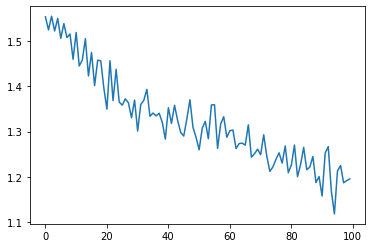

In [36]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluate results

<ipython-input-37-25afdc10806d>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-37-25afdc10806d>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


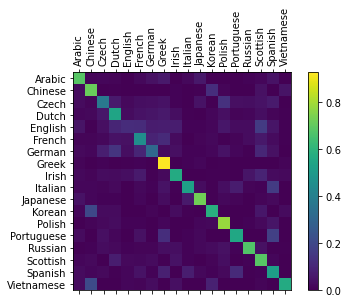

In [37]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_categories):
    confusion[i] = confusion[i]/confusion[i].sum()
    

    # Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Predict

In [44]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)    
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
      






In [45]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.71) Russian
(-0.86) Czech
(-3.04) English

> Jackson
(-0.65) Scottish
(-1.96) English
(-2.31) Greek

> Satoshi
(-0.87) Japanese
(-1.44) Arabic
(-2.55) Italian


# Exercises

### Try with a different dataset of line -> category, for example:
  *  Any word -> language
  *  First name -> gender
  *  Character name -> writer
  *  Page title -> blog or subreddit
### Get better results with a bigger and/or better shaped network
  *  Add more linear layers
  *  Try the nn.LSTM and nn.GRU layers
  *  Combine multiple of these RNNs as a higher level network
